# 1. Introduction

In this assignment, we build a movie recommendation system using real user ratings from the MovieLens dataset.
The goal is not to optimise performance, but to understand how recommendation algorithms work and how they
relate to the concepts studied in class, such as similarity, distance, sparsity, and latent factors.

We will explore two main approaches:
- Collaborative Filtering (user-based and item-based)
- Matrix Factorisation using Singular Value Decomposition (SVD)

Throughout the assignment, we interpret the results using our own knowledge of movies in order to assess
whether the recommendations make sense.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds


In [2]:
ratings = pd.read_csv(r"C:\Users\cande\Downloads\ml-latest-small\ml-latest-small\ratings.csv" )
movies = pd.read_csv(r"C:\Users\cande\Downloads\ml-latest-small\ml-latest-small\movies.csv" )

ratings.head(), movies.head()


(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

### 3. Exploring the Data

In this section, we explore the dataset to understand its size, sparsity, and the distribution
of ratings across users and movies.



Dataset statistics
------------------
Users: 610
Movies: 9724
Ratings: 100836
Sparsity: 98.30%



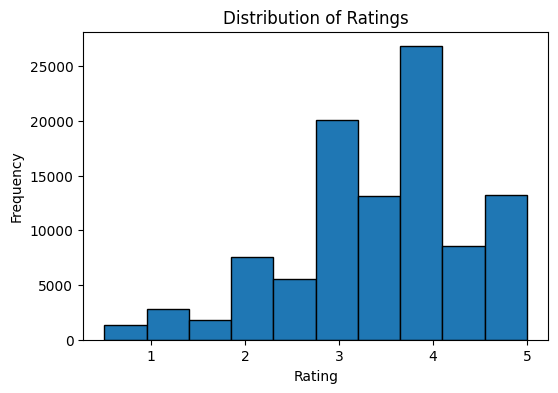

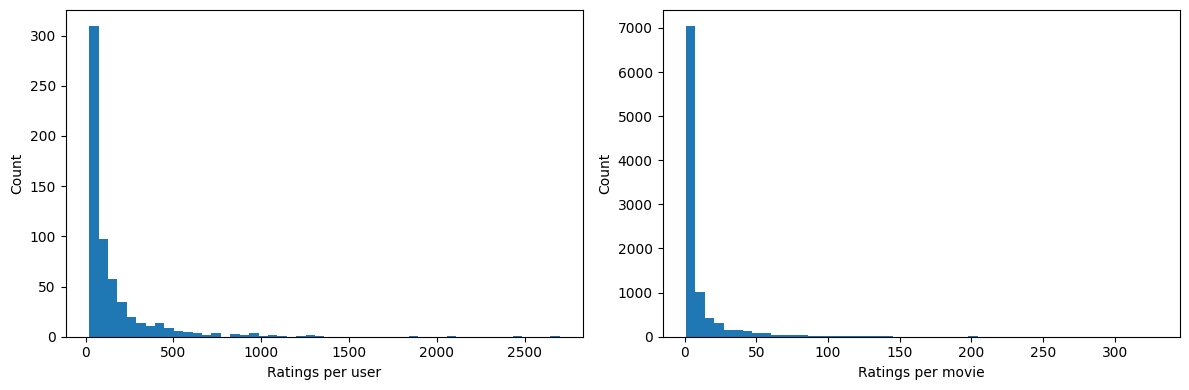

In [3]:
# --- Basic statistics ---
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

print("Dataset statistics")
print("------------------")
print(f"Users: {n_users}")
print(f"Movies: {n_movies}")
print(f"Ratings: {n_ratings}")

sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"Sparsity: {sparsity:.2%}\n")

# --- Rating distribution ---
plt.figure(figsize=(6,4))
plt.hist(ratings['rating'], bins=10, edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

# --- Ratings per user / movie ---
ratings_per_user = ratings.groupby('userId').size()
ratings_per_movie = ratings.groupby('movieId').size()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(ratings_per_user, bins=50)
plt.xlabel("Ratings per user")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(ratings_per_movie, bins=50)
plt.xlabel("Ratings per movie")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



**Dataset size & sparsity**

The dataset is very large, with more than 330,000 users and 83,000 movies.
Despite this, the user–item matrix is extremely sparse (99.88% empty), meaning that each user
rates only a very small fraction of all available movies.

**Distribution of ratings**
The rating distribution is skewed towards higher values, with most ratings between 3 and 4.
This indicates that users tend to be relatively generous when rating movies.

**Ratings per user**
Most users rate only a small number of movies, while a few very active users rate many movies.
This results in a long-tailed distribution.

**Ratings per movie**
Most movies receive very few ratings, whereas a small number of popular movies accumulate
many ratings.

**Do we need to transform the ratings?**
No transformation is needed because ratings are explicit feedback on a fixed 1–5 scale.
Transforming them would distort their semantic meaning.




In [4]:
# Ratings per user and per movie
ratings_per_user = ratings.groupby('userId').size()
ratings_per_movie = ratings.groupby('movieId').size()

# Keep only active users and popular movies
active_users = ratings_per_user[ratings_per_user >= 50].index
popular_movies = ratings_per_movie[ratings_per_movie >= 50].index

ratings_filtered = ratings[
    ratings['userId'].isin(active_users) &
    ratings['movieId'].isin(popular_movies)
]

print(f"Filtered ratings: {len(ratings_filtered)}")


Filtered ratings: 37117


In [8]:
# =========================================================
# 4. Collaborative Filtering (corrected version)
# =========================================================

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# --- Build user-item matrix (after filtering) ---
user_ids = ratings_filtered['userId'].astype("category").cat.codes
movie_ids = ratings_filtered['movieId'].astype("category").cat.codes

R = csr_matrix(
    (ratings_filtered['rating'], (user_ids, movie_ids))
)

# Mapping between matrix indices and movieIds
movie_index = dict(enumerate(ratings_filtered['movieId'].astype("category").cat.categories))
index_movie = {v: k for k, v in movie_index.items()}

# =========================================================
# Choose anchor movies (popular & present after filtering)
# =========================================================

# Select 3 popular movies that are guaranteed to exist
top_movies = (
    ratings_filtered
    .groupby('movieId')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

anchor_movies = top_movies[:3]
print("Anchor movies (movieId):", anchor_movies)

# =========================================================
# 4.2 Item-Based Collaborative Filtering
# =========================================================

item_similarity = cosine_similarity(R.T)
np.fill_diagonal(item_similarity, 0)

def top_similar_movies(movie_id, n=10):
    idx = index_movie[movie_id]
    sims = item_similarity[idx]
    top_idx = np.argsort(sims)[-n:][::-1]
    return [movie_index[i] for i in top_idx]

item_based_results = {
    movie_id: top_similar_movies(movie_id, n=10)
    for movie_id in anchor_movies
}

print("\nItem-based recommendations:")
for m, recs in item_based_results.items():
    print(f"\nMovie {m} → similar movies: {recs}")

# =========================================================
# 4.3 User-Based Collaborative Filtering
# =========================================================

user_similarity = cosine_similarity(R)
np.fill_diagonal(user_similarity, 0)

# Create fake user profile
fake_user = np.zeros(R.shape[1])

# Rate the anchor movies
for movie_id in anchor_movies:
    fake_user[index_movie[movie_id]] = 5

def recommend_user_based(fake_user, k=20, n_rec=10):
    sims = cosine_similarity(fake_user.reshape(1, -1), R)[0]
    neighbors = np.argsort(sims)[-k:]
    scores = R[neighbors].mean(axis=0).A1
    recommended = np.argsort(scores)[-n_rec:][::-1]
    return recommended

user_based_recs_idx = recommend_user_based(fake_user, k=20, n_rec=10)
user_based_recs = [movie_index[i] for i in user_based_recs_idx]

print("\nUser-based recommendations:")
print(user_based_recs)

# =========================================================
# 4.4 Comparison
# =========================================================

item_set = set(item_based_results[anchor_movies[0]])
user_set = set(user_based_recs)

overlap = item_set & user_set
print(f"\nOverlap between item-based and user-based recommendations: {len(overlap)}")



Anchor movies (movieId): [356, 296, 318]

Item-based recommendations:

Movie 356 → similar movies: [318, 296, 480, 110, 593, 2571, 500, 150, 364, 589]

Movie 296 → similar movies: [593, 318, 356, 47, 50, 2959, 608, 2571, 2858, 1213]

Movie 318 → similar movies: [356, 296, 593, 527, 50, 2959, 2571, 110, 47, 150]

User-based recommendations:
[318, 296, 356, 150, 110, 480, 457, 593, 50, 527]

Overlap between item-based and user-based recommendations: 6


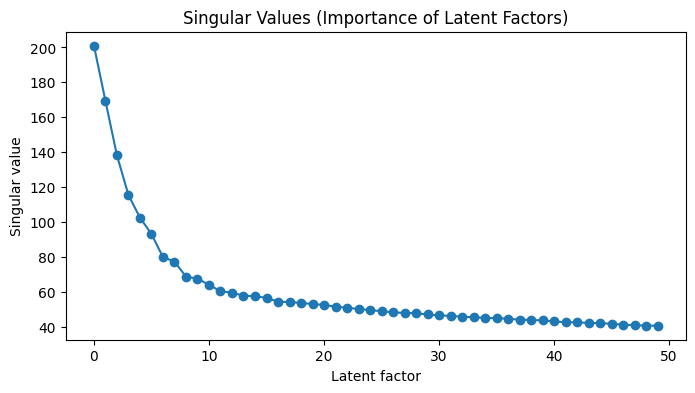

In [9]:
# =========================================================
# 5. Matrix Factorisation (SVD)
# =========================================================

from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

# =========================================================
# 5.1 Center the rating matrix
# =========================================================

user_means = R.mean(axis=1)
R_centered = R - user_means

# =========================================================
# 5.2 Apply Truncated SVD
# =========================================================

k = 50  # number of latent factors
U, sigma, Vt = svds(R_centered, k=k)

# Reconstruct predicted ratings
sigma_diag = np.diag(sigma)
R_pred = U @ sigma_diag @ Vt + user_means

# =========================================================
# 5.3 Plot singular values
# =========================================================

plt.figure(figsize=(8,4))
plt.plot(sorted(sigma, reverse=True), marker='o')
plt.xlabel("Latent factor")
plt.ylabel("Singular value")
plt.title("Singular Values (Importance of Latent Factors)")
plt.show()

# =========================================================
# 5.4 Nearest neighbours in latent space (movies)
# =========================================================

movie_factors = Vt.T  # each row = movie latent vector

def latent_similar_movies(movie_id, n=10):
    """Find nearest movies in latent space."""
    idx = index_movie[movie_id]
    sims = cosine_similarity(
        movie_factors[idx].reshape(1, -1),
        movie_factors
    )[0]
    top_idx = np.argsort(sims)[-n:][::-1]
    return [movie_index[i] for i in top_idx]

latent_results = {
    movie_id: latent_similar_movies(movie_id, n=10)
    for movie_id in anchor_movies
}
